## Libraries

In [1]:
import gc
import os
import sys
import time
import random
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision as vision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

from pathlib import Path
from PIL import Image
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')

from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook
from fastprogress import master_bar, progress_bar

from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

In [2]:
def seed_torch(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=1234)

In [3]:
def get_logger():
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    # handler1
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # handler2
    handler2 = FileHandler(filename=dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".log")
    handler2.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # addHandler
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

## Csv Loading

In [4]:
!ls ../input/imet-2019-fgvc6/

labels.csv  sample_submission.csv  test  train	train.csv


In [5]:
labels = pd.read_csv("../input/imet-2019-fgvc6/labels.csv")
train = pd.read_csv("../input/imet-2019-fgvc6/train.csv")
sample = pd.read_csv("../input/imet-2019-fgvc6/sample_submission.csv")
train.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [6]:
print(labels.attribute_id.nunique())
labels.head()

1103


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [7]:
!cp ../input/pytorch-pretrained-image-models/* ./
!ls

cp: cannot stat '../input/pytorch-pretrained-image-models/*': No such file or directory
2019-04-26-07-14-00.log  __notebook__.ipynb  __output__.json


## DataLoader

In [8]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms["test"] = data_transforms["val"]

# Without KFold, We won't use data_transforms["val"] this time...
# We will use data_transforms["train"] for "..input/train" folders, data_transforms["test"] for "..input/test" folders

In [9]:
class IMetDataset(data.Dataset):
    def __init__(self, datafolder, datatype='train', index=[], device="cuda:0",
                 transform=transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), 
                 labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.index = index
        self.device = device
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train' or self.datatype == 'val':
            if self.index==[]:
                self.image_files_list = [s for s in os.listdir(datafolder)]
                self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
            else:
                self.image_files_list = np.array([s for s in os.listdir(datafolder)])[index]
                self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.image_files_list = [s for s in os.listdir(datafolder)]
            self.labels = [0 for _ in range(len(self.image_files_list))]
        
    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        #img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]
        if self.datatype == 'train' or self.datatype == 'val':
            label = self.labels_dict[img_name_short]
            # Target has some labels, So we need to change labels to tensor
            label_tensor = torch.zeros((1, 1103))
            for i in label:
                label_tensor[0, int(i)] = 1
            label_tensor = label_tensor.to(self.device)
            return image, label_tensor
        else:
            label = 0
            return image, label

## Trainer

In [10]:
class Trainer:
    def __init__(self, model, logger, loss_fn, train_batch=32, valid_batch=128, seed=1234, 
                 device="cuda:0", model_name="best_model"):
        self.model = model
        self.logger = logger
        self.loss_fn = loss_fn.to(device)
        self.train_batch = train_batch
        self.valid_batch = valid_batch
        self.seed = seed
        self.device = device
        self.model_name = model_name
    
    def fit(self, tr_idx, val_idx, img_class_dict, n_epochs=10, num_workers=0):
        # train loader & valid loader
        train_dataset = IMetDataset(datafolder='../input/imet-2019-fgvc6/train/', 
                                    datatype='train', 
                                    index=tr_idx, 
                                    transform=data_transforms["train"], 
                                    labels_dict=img_class_dict)
        train_loader = data.DataLoader(train_dataset, 
                                       batch_size=self.train_batch,
                                       shuffle=True)

        valid_dataset = IMetDataset(datafolder='../input/imet-2019-fgvc6/train/', 
                                    datatype='val', 
                                    index=val_idx, 
                                    transform=data_transforms["val"], 
                                    labels_dict=img_class_dict)
        valid_loader = data.DataLoader(valid_dataset,
                                       batch_size=self.valid_batch,
                                       shuffle=False)
        # model
        model = self.model
        model.to(self.device)
        # optimizer
        optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
        # scheduler
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
        # set best_score
        best_score = np.inf
        # master_bar
        mb = master_bar(range(n_epochs))
        for epoch in mb:
            model.train()
            avg_loss = 0.0
            train_losses = []
            for i_batch, y_batch in progress_bar(train_loader, parent=mb):
                # zero the parameter gradients
                optimizer.zero_grad()
                # pred & loss
                y_pred = model(i_batch.cuda())
                y_batch = y_batch.view(y_batch.size()[0], -1) # flatten y_batch
                loss = self.loss_fn(y_pred, y_batch)
                #self.logger.info("loss: {}".format(loss))
                # backward + optimize in training phase
                loss.backward()
                optimizer.step()
                # avg_loss
                avg_loss = loss.item()
                train_losses.append(avg_loss)
                #avg_loss += loss.item() / len(train_loader)
                #self.logger.info("avg_loss: {:.8f}    loss.item(): {}    len(train_loader): {}"\
                             #.format(avg_loss, loss.item(), len(train_loader)))
            # val
            valid_preds, valid_y, avg_val_loss = self.val(valid_loader, model)
            scheduler.step()
            # save best model
            if best_score > avg_val_loss:
                torch.save(model.state_dict(), self.model_name+".pth")
                torch.save(optimizer.state_dict(), "optimizer.pth")
                torch.save(scheduler.state_dict(), "scheduler.pth")
                best_score = avg_val_loss
            # logger
            self.logger.info("Epoch {} / {} ".format(epoch+1, n_epochs))
            #self.logger.info("avg_loss: {:.8f}    avg_val_loss: {:.8f}    best_avg_val_loss: {:.8f}"\
                             #.format(avg_loss, avg_val_loss, best_score))
            self.logger.info("avg_loss: {:.8f}    avg_val_loss: {:.8f}    best_avg_val_loss: {:.8f}"\
                             .format(sum(train_losses[-100:])/len(train_losses[-100:]), avg_val_loss, best_score))
        # output of best model      
        model.load_state_dict(torch.load(self.model_name+".pth"))
        # eval
        valid_preds, valid_y, _ = self.val(valid_loader, model)
        return valid_preds, valid_y
    
    def val(self, loader, model):
        model.eval()
        valid_preds = np.zeros((len(loader.dataset), 1103))
        valid_y = np.zeros((len(loader.dataset), 1103))
        avg_val_loss = 0.0
        for i, (i_batch, y_batch) in enumerate(loader):
            with torch.no_grad():
                y_pred = model(i_batch.cuda()).detach()
                y_batch = y_batch.view(y_batch.size()[0], -1) # flatten y_batch
                avg_val_loss += self.loss_fn(y_pred, y_batch).item() / len(loader)
                if i_batch.size()[0]==self.valid_batch:
                    valid_preds[i * self.valid_batch : (i+1) * self.valid_batch] = y_pred.cpu().numpy()
                    valid_y[i * self.valid_batch : (i+1) * self.valid_batch] = y_batch.cpu().numpy()
                else:
                    valid_preds[len(loader.dataset) - i_batch.size()[0] : ] = y_pred.cpu().numpy()
                    valid_y[len(loader.dataset) - i_batch.size()[0] : ] = y_batch.cpu().numpy()
        return valid_preds, valid_y, avg_val_loss
    
    def predict(self, loader):
        model = self.model
        model.load_state_dict(torch.load(self.model_name+".pth"))
        model.to(self.device)
        model.eval()
        preds = np.zeros((len(loader.dataset), 1103))
        for i, (i_batch, _) in enumerate(loader):
            with torch.no_grad():
                y_pred = model(i_batch.cuda()).detach()
                if i_batch.size()[0]==self.valid_batch:
                    preds[i * self.valid_batch : (i+1) * self.valid_batch] = y_pred.cpu().numpy()
                else:
                    preds[len(loader.dataset) - i_batch.size()[0] : ] = y_pred.cpu().numpy()
        return preds

## Model

In [11]:
model_conv = models.resnet18(pretrained='imagenet')
#for i, param in model_conv.named_parameters():
    #param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 108387067.01it/s]


In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
    def forward(self, x):
        return x

num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 1103)
model_conv.fc = Classifier()

In [13]:
# 2層のMLP
mlp = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),
    nn.ReLU(),
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.25),
    nn.Linear(num_ftrs, 1103)
)

In [14]:
# 最終的なCNN
net = nn.Sequential(
    model_conv,
    mlp,
    nn.Sigmoid()
)

In [15]:
#net

In [16]:
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# Training

In [17]:
loss_fn = nn.BCELoss(reduction="mean")
#loss_fn = FocalLoss()
trainer = Trainer(net, logger, loss_fn, train_batch=32, valid_batch=128, seed=1234, device="cuda:0")

In [18]:
# indices for validation
tr, val = train_test_split(train.id, test_size=0.2, random_state=1234)
tr, val = tr.index, val.index
#tr, val = list(tr), list(val)
# X_train, y_train, X_val, y_val
img_class_dict = {k:v for k, v in zip(train.id, train.attribute_ids.map(lambda x: x.split()).values)}

In [19]:
valid_preds, valid_y = trainer.fit(tr, val, img_class_dict, n_epochs=20, num_workers=0)

2019-04-26 07:34:00,235     INFO Epoch 1 / 20 
2019-04-26 07:34:00,237     INFO avg_loss: 0.01563551    avg_val_loss: 0.01544282    best_avg_val_loss: 0.01544282


## Post process - threshold search -

Since I used sigmoid for the activation, I've got the 1103 probability output for each data row.

I need to decide threshold for this.There are two ways to deal with this.

- Class-wise threshold search
  - Takes some time but it's natural.
- One threshold for all the class
  - Low cost way.

**UPDATE**
I will use the first -> second one.

In [20]:
def threshold_search(y_pred, y_true):
    score = []
    candidates = np.arange(0, 0.4, 0.01)
    for th in progress_bar(candidates):
        yp = (y_pred > th).astype(int)
        score.append(fbeta_score(y_pred=yp, y_true=y_true, beta=2, average="samples"))
    score = np.array(score)
    pm = score.argmax()
    best_th, best_score = candidates[pm], score[pm]
    plt.plot(candidates, score)
    plt.vlines(x=best_th, ymin=score.min(), ymax=score.max())
    plt.text(best_th+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
    plt.show()
    return best_th, best_score

In [21]:
'''
y = train.attribute_ids.map(lambda x: x.split()).values
y_true = np.zeros((train.shape[0], 1103)).astype(int)
for i, row in enumerate(y):
    for idx in row:
        y_true[i, int(idx)] = 1
        '''

'\ny = train.attribute_ids.map(lambda x: x.split()).values\ny_true = np.zeros((train.shape[0], 1103)).astype(int)\nfor i, row in enumerate(y):\n    for idx in row:\n        y_true[i, int(idx)] = 1\n        '

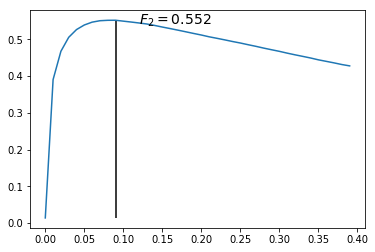

In [22]:
best_threshold, best_score = threshold_search(valid_preds, valid_y)

## Prediction for test data

In [23]:
#test_preds = trainer.predict(test_loader)

In [24]:
#preds = (test_preds > best_threshold).astype(int)

In [25]:
'''
prediction = []
for i in range(preds.shape[0]):
    pred1 = np.argwhere(preds[i] == 1.0).reshape(-1).tolist()
    pred_str = " ".join(list(map(str, pred1)))
    prediction.append(pred_str)
    
sample.attribute_ids = prediction
sample.to_csv("submission.csv", index=False)
sample.head()
'''

'\nprediction = []\nfor i in range(preds.shape[0]):\n    pred1 = np.argwhere(preds[i] == 1.0).reshape(-1).tolist()\n    pred_str = " ".join(list(map(str, pred1)))\n    prediction.append(pred_str)\n    \nsample.attribute_ids = prediction\nsample.to_csv("submission.csv", index=False)\nsample.head()\n'